In [ ]:
import requests
from bs4 import BeautifulSoup
import re
from pypac import PACSession, get_pac
import urllib3
import hashlib
import time
import json

# Suppress InsecureRequestWarning
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Load PAC file and create PACSession
pac = get_pac(url='http://127.0.0.1:9001/localproxy-2816cff9.pac')
session = PACSession(pac)

# List of predefined brands
brands = ["Alfa Romeo", "Kia", "Lexus", "Porsche","Jeep","MG","Suzuki", "Nissan","Subaru","Polestar", "Aston", "Dodge", "Jaguar", "Seat", "Cupra", "Land Rover", "Škoda", "Mitsubishi", "Mini", "Honda", "Lancia", "SsangYong", "Audi", "Ford", "Opel", "Toyota", "BMW", "Hyundai", "Peugeot", "Volkswagen", "Citroën", "Dacia", "Mazda", "Renault", "Volvo", "Fiat", "Mercedes-Benz", "Tesla"]

def detect_brand(car_name):
    for brand in brands:
        if brand.lower() in car_name.lower():
            return brand
    return "Unknown"

def generate_unique_id(name, kilometers, price):
    hash_input = f"{name}{kilometers}{price}".encode('utf-8')
    return hashlib.md5(hash_input).hexdigest()

def scrap_price(pages_to_scrape, existing_cars):
    cars = existing_cars.copy()
    for page in range(1, pages_to_scrape + 1):
        url = f"https://www.sauto.cz/inzerce/osobni/?strana={page}"
        # Make the request using the PACSession with SSL verification disabled
        response = session.get(url, verify=False)
        if response.status_code != 200:
            print(f"Error: Failed to retrieve page {page}. Status code: {response.status_code}")
            continue

        soup = BeautifulSoup(response.text, "html.parser")
        
        # Find the list containing car elements
        car_list = soup.find('ul', class_='c-item-list__list')
        if not car_list:
            print(f"Error: No car list found on page {page}.")
            continue

        # Find all car elements within the list and take the first 17
        car_elements = car_list.find_all('li', class_='c-item')[:17]
        
        for element in car_elements:
            car_container = element.find('div', class_='c-item__container')
            car_content = car_container.find('div', class_='c-item__content')
            car_data_wrap = car_content.find('div', class_='c-item__data-wrap')
            
            car_link = car_data_wrap.find('a', class_='c-item__link')
            car_name_element = car_link.find('span', class_='c-item__name')
            car_model_element = car_link.find('span', class_='c-item__name--suffix')
            car_price_element = car_data_wrap.find('div', class_='c-item__data').find('div', class_='c-item__price')
            car_info_element = car_data_wrap.find('div', class_='c-item__info')
            
            if car_name_element and car_model_element and car_price_element and car_info_element:
                car_full_name = car_name_element.text.strip()
                car_model = car_model_element.text.strip()
                car_price = car_price_element.text.strip()
                car_info = car_info_element.text.strip()

                # Use regex to split the name and detail based on the first comma
                match = re.match(r'^(.*?)(,.*)$', car_model)
                if match:
                    car_model = match.group(1).strip()
                    detail = match.group(2).strip()
                else:
                    car_model = car_model.strip()
                    detail = ""

                # Detect brand
                brand = detect_brand(car_full_name)
                
                # Remove currency symbols and non-breaking spaces, convert price to integer (if possible)
                car_price = car_price.replace('Kč', '').replace('\xa0', '').replace(',', '').strip()
                try:
                    car_price = int(car_price)
                except ValueError:
                    car_price = 'N/A'
                
                # Extract age and kilometers driven
                car_info_parts = car_info.split(',')
                age_of_car = car_info_parts[0].strip()
                kilometers_driven = car_info_parts[1].replace('\xa0', '').strip()

                # Extract name from model
                name_parts = car_full_name.split(',')
                car_name = name_parts[0].strip()
                if len(name_parts) > 1:
                    car_model = name_parts[1].strip()
                
                # Generate unique ID
                unique_id = generate_unique_id(car_name, kilometers_driven, car_price)
                
                # Check for duplicates
                if unique_id not in [car['id'] for car in cars]:
                    cars.append({
                        'id': unique_id,
                        'brand': brand,
                        'name': car_name,
                        'detail': car_model,
                        'price': car_price,
                        'age': age_of_car,
                        'kilometers': kilometers_driven
                    })
                else:
                    print(f"Duplicate car detected: {car_name}, skipping.")
            else:
                print(f"Error: Missing car name, model, price, or info element on page {page}.")
        
        # Add a delay between requests to avoid rate limiting
        #time.sleep(1)
    
    return cars

def save_to_file(sorted_car_list, filename):
    # Group cars by brand
    grouped_cars = {}
    for car in sorted_car_list:
        if car['brand'] not in grouped_cars:
            grouped_cars[car['brand']] = []
        grouped_cars[car['brand']] = sorted(grouped_cars[car['brand']] + [car], key=lambda x: x['price'] if x['price'] != 'N/A' else float('inf'))
    
    # Write to file
    with open(filename, 'w', encoding='utf-8') as file:
        for brand in grouped_cars:
            file.write(f"Brand: {brand}\n")
            for car in grouped_cars[brand]:
                file.write(f"- ID: {car['id']}, Name: {car['name']}, Price: {car['price']} Kč, KM Driven: {car['kilometers']}, Year: {car['age']}\n")
            file.write("\n")

def load_existing_cars(filename):
    try:
        with open(filename, 'r', encoding='utf-8') as file:
            return json.load(file)
    except (FileNotFoundError, json.JSONDecodeError):
        return []

def save_cars_to_json(cars, filename):
    with open(filename, 'w', encoding='utf-8') as file:
        json.dump(cars, file, ensure_ascii=False, indent=4)

# Number of pages to scrape, 500 is MAX
pages_to_scrape = 500
json_filename = 'scraped_cars.json'

# Load existing cars from JSON file
existing_cars = load_existing_cars(json_filename)

# Scrape new cars and merge with existing cars
scraped_cars = scrap_price(pages_to_scrape, existing_cars)

# Save the merged car list to JSON file
save_cars_to_json(scraped_cars, json_filename)

# Save the sorted list to a text file
save_to_file(scraped_cars, 'sorted_cars.txt')

print("The sorted car list has been saved to sorted_cars.txt and scraped_cars.json.")


Duplicate car detected: Volkswagen Passat, skipping.
Duplicate car detected: Škoda Superb, skipping.
Duplicate car detected: Nissan Pulsar, skipping.
Duplicate car detected: Škoda Favorit, skipping.
Duplicate car detected: Mercedes-Benz Třídy A, skipping.
Duplicate car detected: BMW X3, skipping.
Duplicate car detected: Volkswagen Touareg, skipping.
Duplicate car detected: Hyundai ix20, skipping.
Duplicate car detected: Citroën C3, skipping.
Duplicate car detected: Tesla Model 3, skipping.
Duplicate car detected: Subaru XV, skipping.
Duplicate car detected: Kia Cee´d, skipping.
Duplicate car detected: Hyundai Tucson, skipping.
Duplicate car detected: BMW X6, skipping.
Duplicate car detected: Mercedes-Benz Třídy E, skipping.
Duplicate car detected: Toyota Corolla, skipping.
Duplicate car detected: Volkswagen Passat, skipping.
Duplicate car detected: Dodge Ram, skipping.
Duplicate car detected: Audi A6 allroad, skipping.
Duplicate car detected: Land Rover Discovery, skipping.
Duplicate c

In [13]:
import json

# Define "cars" by loading it from the JSON file
json_filename = 'scraped_cars.json'
with open(json_filename, 'r', encoding='utf-8') as file:
    cars = json.load(file)

len(cars)

9223

                                 ID       Brand               Name  \
0  0d0fc201f2f76751fc9affcb11431651       Škoda        Škoda Kamiq   
1  e30c8392719f83c9b3e8a8f40ae9b2a7       Dacia        Dacia Logan   
2  0cb54e81ec12a715eed933f3b4233ccd       Škoda       Škoda Superb   
3  5656580284120a3e4b93dbd36773054b  Volkswagen  Volkswagen Passat   
4  7c53b032c47cb9656148eafe58fdaaa5       Škoda       Škoda Superb   

                           Detail   Price   Age  Kilometers  
0  Style+ 1.5 TSI 110kw DSG tažné  439000  2020      145680  
1                               1   77500  2012      148000  
2              2.0 TDI COMF 99tkm  430000  2017       99500  
3  2.0TDi Webasto tažné LED park.  215000  2012      199000  
4                               2  459000  2020      248600  


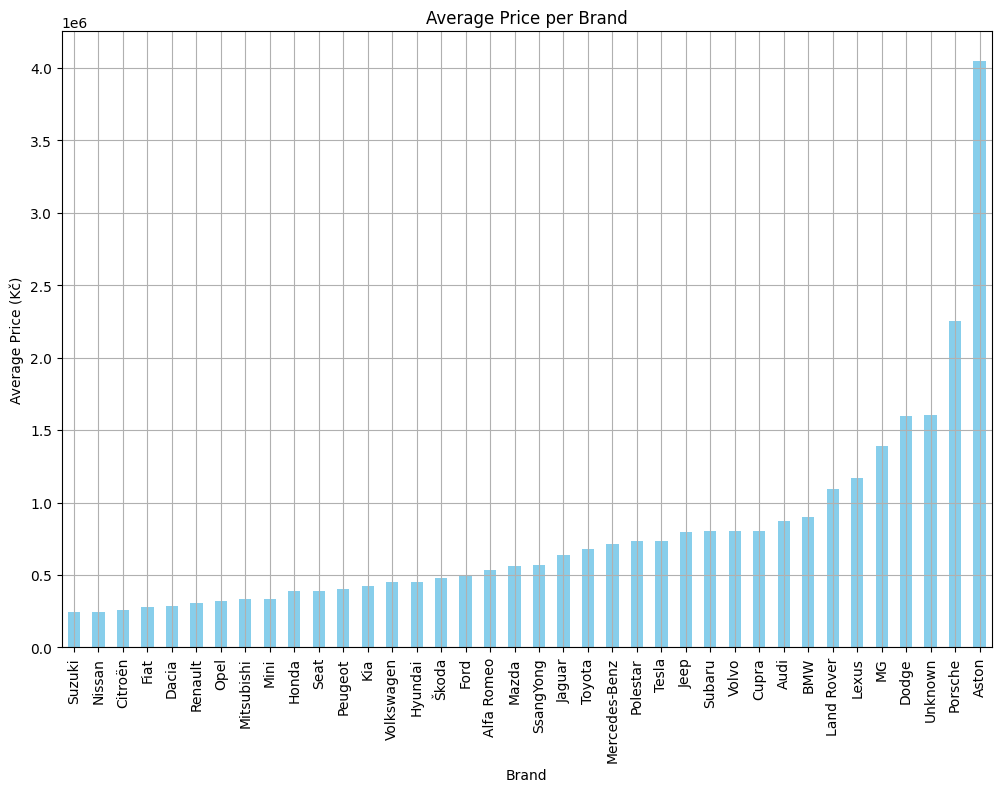

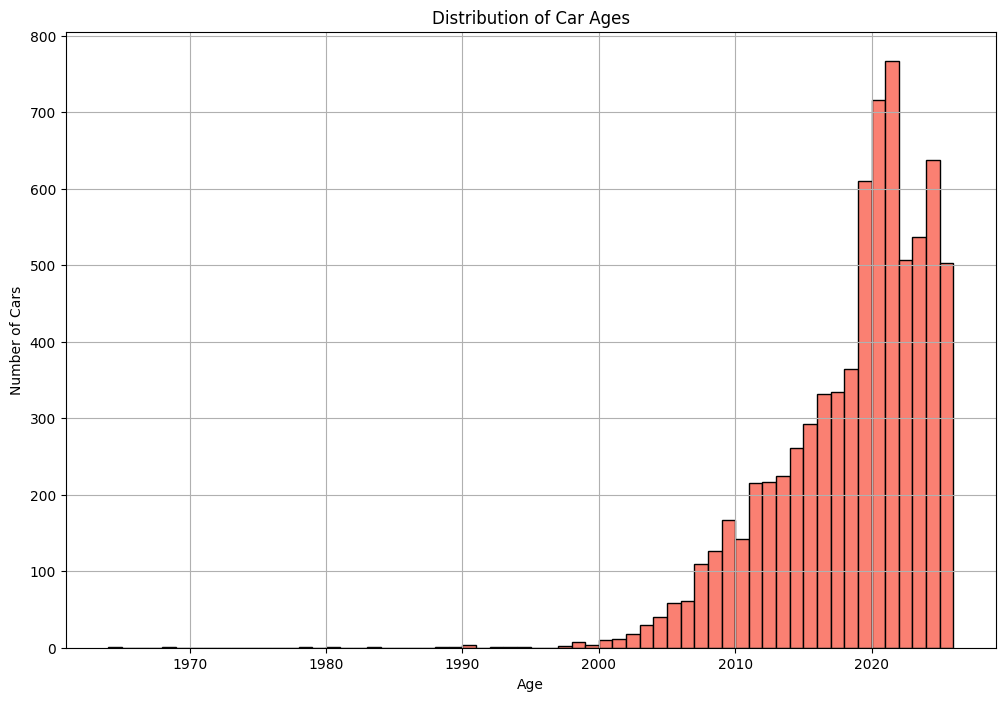

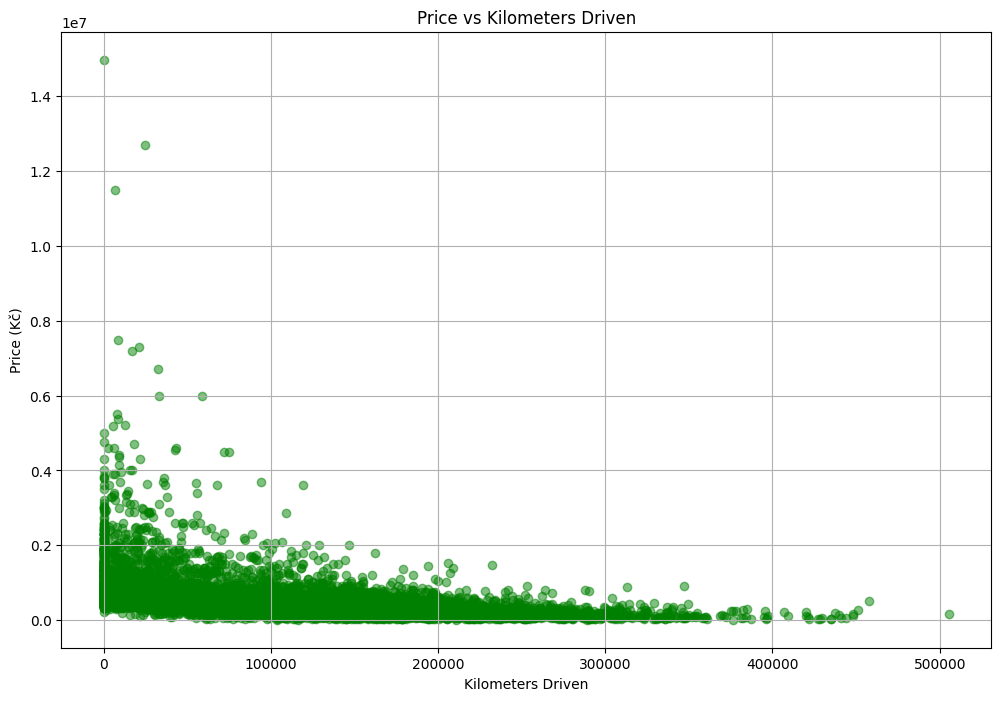

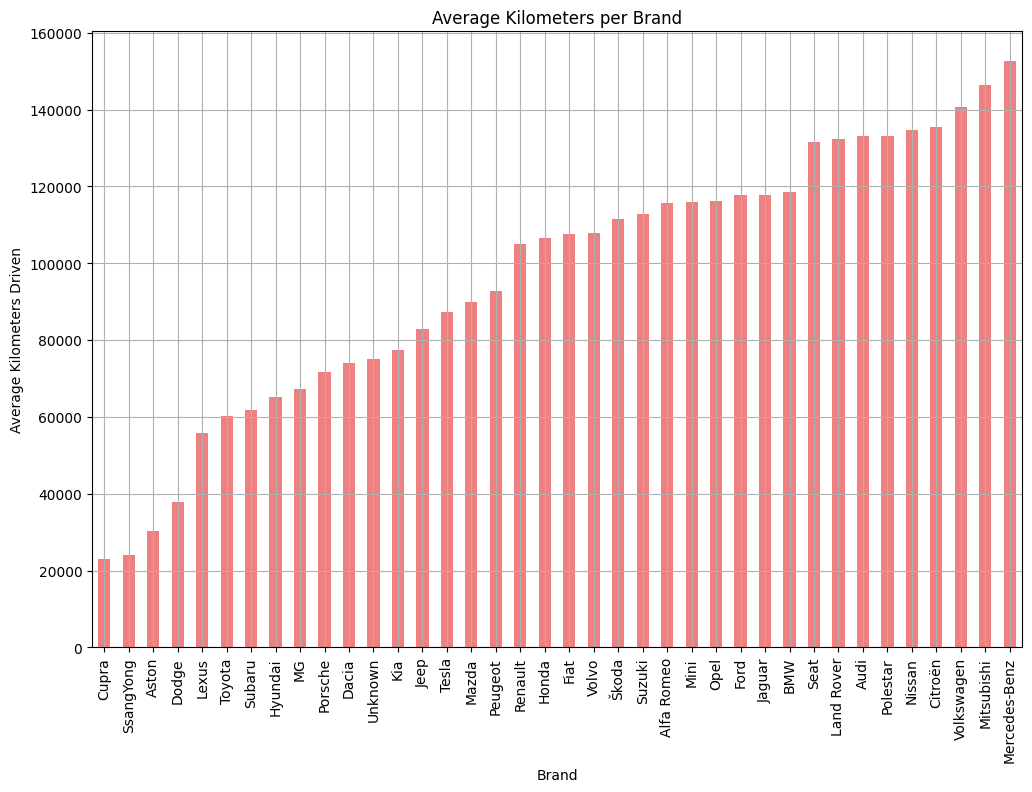

In [12]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Load data from JSON file
json_filename = 'scraped_cars.json'
with open(json_filename, 'r', encoding='utf-8') as file:
    cars = json.load(file)

# Convert kilometers to integer
def convert_kilometers(km_string):
    return int(km_string.replace(' km', '').replace('\xa0', '').replace(',', '').strip())

# Create a DataFrame from the JSON data
data = {
    'ID': [car['id'] for car in cars],
    'Brand': [car['brand'] for car in cars],
    'Name': [car['name'] for car in cars],
    'Detail': [car.get('detail', '') for car in cars],
    'Price': [car['price'] for car in cars],
    'Age': [int(car['age']) for car in cars],
    'Kilometers': [convert_kilometers(car['kilometers']) for car in cars]
}

df = pd.DataFrame(data)

# Display the DataFrame
print(df.head())

# Plot 1: Average price per brand
avg_price_per_brand = df.groupby('Brand')['Price'].mean().sort_values()
plt.figure(figsize=(12, 8))
avg_price_per_brand.plot(kind='bar', color='skyblue')
plt.title('Average Price per Brand')
plt.xlabel('Brand')
plt.ylabel('Average Price (Kč)')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

# Plot 2: Distribution of car ages
plt.figure(figsize=(12, 8))
df['Age'].hist(bins=range(df['Age'].min(), df['Age'].max() + 1), color='salmon', edgecolor='black')
plt.title('Distribution of Car Ages')
plt.xlabel('Age')
plt.ylabel('Number of Cars')
plt.grid(True)
plt.show()

# Plot 3: Price vs Kilometers
plt.figure(figsize=(12, 8))
plt.scatter(df['Kilometers'], df['Price'], alpha=0.5, c='green')
plt.title('Price vs Kilometers Driven')
plt.xlabel('Kilometers Driven')
plt.ylabel('Price (Kč)')
plt.grid(True)
plt.show()

# Plot 4: Average kilometers per brand
avg_kilometers_per_brand = df.groupby('Brand')['Kilometers'].mean().sort_values()
plt.figure(figsize=(12, 8))
avg_kilometers_per_brand.plot(kind='bar', color='lightcoral')
plt.title('Average Kilometers per Brand')
plt.xlabel('Brand')
plt.ylabel('Average Kilometers Driven')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


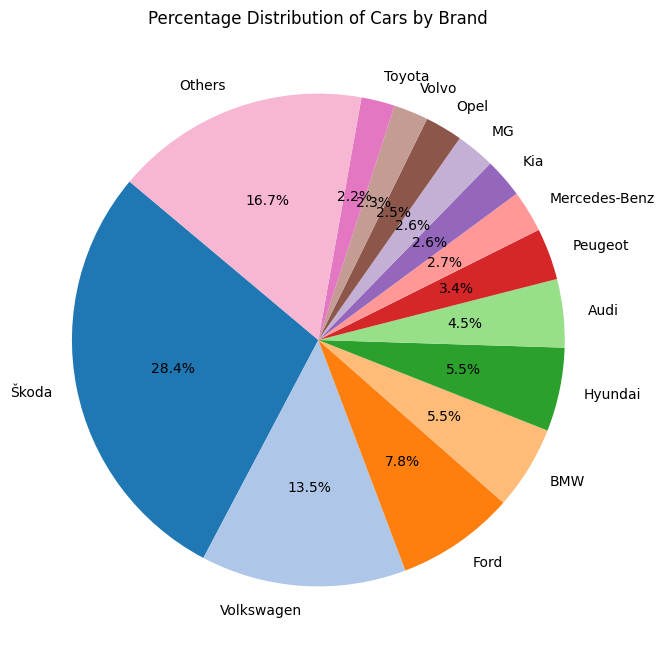

In [14]:
# Calculate the percentage of cars per brand
brand_distribution = df['Brand'].value_counts(normalize=True) * 100

# Separate brands under 2%
small_brands = brand_distribution[brand_distribution < 2]
small_brands_percentage = small_brands.sum()

# Remove small brands and add "Others"
filtered_distribution = brand_distribution[brand_distribution >= 2]
filtered_distribution['Others'] = small_brands_percentage

# Plot pie chart
plt.figure(figsize=(10, 8))
filtered_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
plt.title("Percentage Distribution of Cars by Brand")
plt.ylabel("")
plt.show()

In [15]:
# Calculate the percentage of cars per brand
brand_distribution = df['Brand'].value_counts(normalize=True) * 100

# Separate brands under 2%
small_brands = brand_distribution[brand_distribution < 2]
small_brands_percentage = small_brands.sum()

# Plot pie chart of small brands to create legend for "Others"
plt.figure(figsize=(10, 8))
small_brands.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
plt.title("Small Brands (<2%) Representing 'Others'")
plt.ylabel("")
plt.legend(title="Small Brands", loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()



NameError: name 'df' is not defined

The pie chart showing the percentage distribution of cars by brand (combining smaller brands as "Others") has been created. Let me know if you need further adjustments or analysis.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4aab344c-a663-4ddf-8722-7af8781742df' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>